# Finite Volume Advection Equation
Solving $u_t+au_x = 0 $ using finite volumes with options for:
- first order upwind
- second order central upwind
- third order upwind
- flux limiting


In [1]:
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.color_palette('colorblind')
from scipy import stats

In [68]:
def first_order_upwind(U, c, n, J):
    for j in range(J+1):
        if j==0:
            flux_left = 0
        else:
            flux_left = flux_right

        if j < J:
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
        else:
            flux_right = 0

        U[n+1, j] = U[n,j] + (flux_left - flux_right)

    return U

def second_order_upwind(U, c, n, J):
    for j in range(J+1):
        if j==0:
            flux_left = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            flux_right = (min(c,0)*(U[n, j+1] + 0.5*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] + 0.5*(U[n, j+1] - U[n, j])))
        elif j==J-1 or j==1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
        else:
            flux_right = 0

        U[n+1, j] = U[n,j] + (flux_left - flux_right)

    return U

def third_order_upwind(U, c, n, J):
    eps = 10**-8
    def psi(theta): return 1/3 + (1/6)*theta
    for j in range(J+1):  
        if j==0:
            flux_left = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            theta = (U[n,j] - U[n,j-1]) / (U[n,j+1] - U[n,j] + eps) 
            flux_right = (min(c,0)*(U[n, j+1] + psi(1/(theta+eps))*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] +  psi(theta)*(U[n, j+1] - U[n, j])))
        elif j==J-1 or j==1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
        else:
            flux_right = 0

        U[n+1, j] = U[n,j] + (flux_left - flux_right)

    return U

def flux_limited_upwind(U, c, n, J):
    eps = 10**-8
    def psi(theta): return max(0,min(1, 1/3 + (1/6)*theta, theta))
    for j in range(J+1):  
        if j==0:
            flux_left = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            theta = (U[n,j] - U[n,j-1]) / (U[n,j+1] - U[n,j] + eps) 
            flux_right = (min(c,0)*(U[n, j+1] + psi(1/(theta+eps))*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] +  psi(theta)*(U[n, j+1] - U[n, j])))
            
        elif j==J-1 or j==1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])

        else:
            flux_right = 0

        U[n+1, j] = U[n,j] + (flux_left - flux_right) 

    return U

def solve_adv_eqn(solver=first_order_upwind, a=1, dt=0.001, dx=0.1, T_end=5, L=5,
                initial_dist=(lambda x: stats.norm.pdf(x, loc=0, scale=0.2))):
    t = np.arange(0, T_end+dt, dt)
    x = np.arange(-L, L+dx , dx)

    N = len(t)-1
    J = len(x)-1
    U = np.zeros((N+1, J+1), dtype= float)

    U_0 = initial_dist(x) #Initial Conditions
    U[0,] = U_0
    c = a * (dt/dx)
    if abs(c)>1:
        warnings.warn('Method is likely to be unstable, CFL condition failed, c>1')
    for n in range(N):
        sol = solver(U, c, n, J)
    mass_loss =  (1 - sum(U[-1,:])/sum(U[0,:]))*100
    print('{} mass loss was {:.5f}%'.format(solver.__name__, mass_loss))
    return x, sol

first_order_upwind mass loss was 0.00000%
second_order_upwind mass loss was 0.00000%
third_order_upwind mass loss was 0.00000%
flux_limited_upwind mass loss was 0.00000%


C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


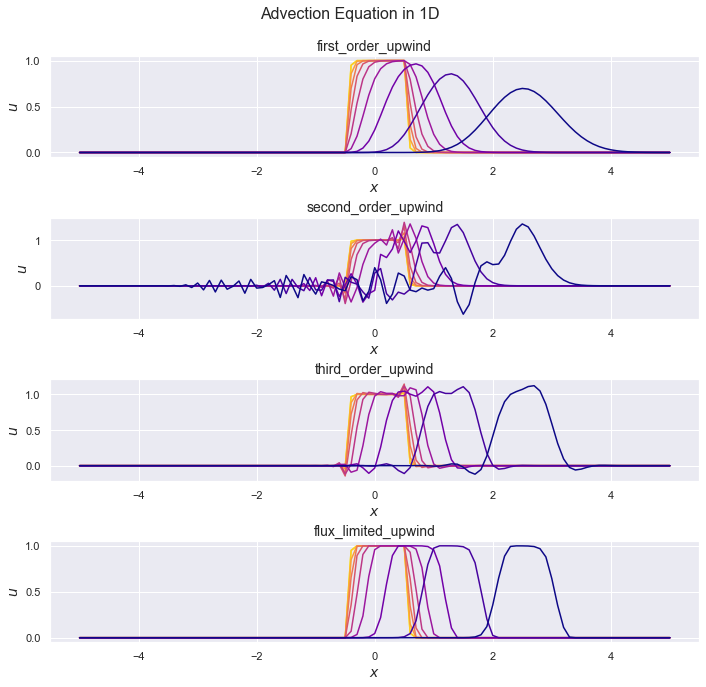

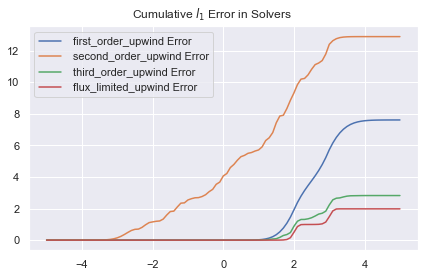

In [70]:
colormap = plt.get_cmap('plasma')
adv_solvers = [first_order_upwind, second_order_upwind, third_order_upwind, flux_limited_upwind]

def block(x): return np.array([int(i>=-0.5 and i<=0.5) for i in x])
def gaussian(x): return stats.norm.pdf(x, loc=-1, scale=1)
initial_data = block
wavespeed = 0.5
T_final = 5

fig, ax = plt.subplots(len(adv_solvers), 1, figsize=(10,10))
fig.suptitle('Advection Equation in 1D', fontsize=16)
err_fig, err_ax= plt.subplots()
if len(adv_solvers)==1:
    ax = [ax]

for idx, solver in enumerate(adv_solvers):
    adv_x, adv_sol = solve_adv_eqn(solver=solver, a=wavespeed, T_end=T_final, dx=0.1,
                                   dt=0.01, initial_dist=initial_data)
    ax[idx].set_title(solver.__name__, fontsize=14)
    ax[idx].set_xlabel(r'$x$', fontsize=14)
    ax[idx].set_ylabel(r'$u$', fontsize=14)
    ax[idx].set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
    for i in np.logspace(0, np.log10(np.size(adv_sol, axis=0)-1), num=10):
        ax[idx].plot(adv_x, adv_sol[int(i),])
    
    true_sol = initial_data(adv_x-wavespeed*T_final)
    err_ax.plot(adv_x, np.cumsum(abs(true_sol - adv_sol[-1,])), label=' {} Error'.format(solver.__name__))
    err_ax.legend()

err_fig.suptitle(r'Cumulative $l_1$ Error in Solvers')
err_fig.show()    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.6)
fig.show()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
savepath = './'
plt.savefig(savepath+'{}.jpg'.format('upwind'), format='jpg', dpi=1000)
plt.show()


# Advection-Diffusion Equation
Add in a diffusive term, $\sigma \frac{\mathrm{d}^2 u}{\mathrm{d}x^2}$. Solve using Crank-Nicolson

In [64]:
def first_order_upwind(U, a, D, dt, dx, n, J):
    c = a*(dt/dx)
    mu = D * dt/(dx**2)
    t_a = 0.5*mu
    t_b = 1 + mu
    t_c = 0.5*mu

    t_d, t_e, t_f = [np.zeros(J+1) for _ in range(3)]


    for j in range(J+1):
        if j==0:
            flux_left = 0
        else:
            flux_left = flux_right

        if j < J:
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
            diff = 0.5 *D*(dt/dx**2) * (U[n,j+1] -2*U[n,j] + U[n,j-1])
                
        else:
            flux_right = 0

        t_d[j] = U[n, j] + diff + (flux_left-flux_right)
        t_e[j] = t_c/(t_b - t_a*t_e[j-1])
        t_f[j] = (t_d[j] + t_a*t_f[j-1]) / (t_b - t_a*t_e[j-1])

    for j in range(J, 0, -1):
        if j==0 or j==J:
            U[n+1,j] = 0
        else:
            U[n+1, j] = t_f[j] + t_e[j]*U[n+1, j+1]

    return U

def second_order_upwind(U, a, D, dt, dx, n, J):
    c = a*(dt/dx)
    mu = D * dt/(dx**2)
    t_a = 0.5*mu
    t_b = 1 + mu
    t_c = 0.5*mu

    t_d, t_e, t_f = [np.zeros(J+1) for _ in range(3)]

    for j in range(J+1):
        if j==0:
            flux_left = 0
            diff = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            flux_right = (min(c,0)*(U[n, j+1] + 0.5*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] + 0.5*(U[n, j+1] - U[n, j])))
            diff = 0.5 *D*(dt/dx**2) * (U[n,j+1] -2*U[n,j] + U[n,j-1])
            
        elif j==1 or j==J-1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
            diff = 0.5 *D*(dt/dx**2) * (U[n,j+1] -2*U[n,j] + U[n,j-1])
            
        else:
            flux_right = 0

        t_d[j] = U[n, j] + diff + (flux_left-flux_right)
        t_e[j] = t_c/(t_b - t_a*t_e[j-1])
        t_f[j] = (t_d[j] + t_a*t_f[j-1]) / (t_b - t_a*t_e[j-1])

    for j in range(J, 0, -1):
        if j==0 or j==J:
            U[n+1,j] = 0
        else:
            U[n+1, j] = t_f[j] + t_e[j]*U[n+1, j+1]

    return U

def third_order_upwind(U, a, D, dt, dx, n, J):
    c = a*(dt/dx) 
    mu = D * dt/(dx**2)
    t_a = 0.5*mu
    t_b = 1 + mu
    t_c = 0.5*mu

    t_d, t_e, t_f = [np.zeros(J+1) for _ in range(3)]

    eps = 10**-8
    def psi(theta): return 1/3 + (1/6)*theta
    for j in range(J+1):  
        if j==0:
            flux_left = 0
            diff = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            theta = (U[n,j] - U[n,j-1]) / (U[n,j+1] - U[n,j] + eps) 
            flux_right = (min(c,0)*(U[n, j+1] + psi(1/(theta+eps))*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] +  psi(theta)*(U[n, j+1] - U[n, j])))
            diff = 0.5 *D*(dt/dx**2) * (U[n,j+1] -2*U[n,j] + U[n,j-1])
    
        elif j==J-1 or j==1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
            diff = 0.5 *D*(dt/dx**2) * (U[n,j+1] -2*U[n,j] + U[n,j-1])    
        else:
            flux_right = 0
            
        t_d[j] = U[n, j] + diff + (flux_left-flux_right)
        t_e[j] = t_c/(t_b - t_a*t_e[j-1])
        t_f[j] = (t_d[j] + t_a*t_f[j-1]) / (t_b - t_a*t_e[j-1])

    for j in range(J, 0, -1):
        if j==0 or j==J:
            U[n+1,j] = 0
        else:
            U[n+1, j] = t_f[j] + t_e[j]*U[n+1, j+1]

    return U

def flux_limited_upwind(U, a, D, dt, dx, n, J):
    c = a*(dt/dx)
    mu = D * dt/(dx**2)
    t_a = 0.5*mu
    t_b = 1 + mu
    t_c = 0.5*mu

    t_d, t_e, t_f = [np.zeros(J+1) for _ in range(3)]
    
    eps = 10**-8
    def psi(theta): return max(0,min(1, 1/3 + (1/6)*theta, theta))
    for j in range(J+1):  
        if j==0:
            flux_left = 0
            diff = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            theta = (U[n,j] - U[n,j-1]) / (U[n,j+1] - U[n,j] + eps) 
            flux_right = (min(c,0)*(U[n, j+1] + psi(1/(theta+eps))*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] +  psi(theta)*(U[n, j+1] - U[n, j])))
            diff = 0.5 *D*(dt/dx**2) * (U[n,j+1] -2*U[n,j] + U[n,j-1])  
        elif j==J-1 or j==1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
            diff = 0.5 *D*(dt/dx**2) * (U[n,j+1] -2*U[n,j] + U[n,j-1]) 
            
        else:
            flux_right = 0
        t_d[j] = U[n, j] + diff + (flux_left-flux_right)
        t_e[j] = t_c/(t_b - t_a*t_e[j-1])
        t_f[j] = (t_d[j] + t_a*t_f[j-1]) / (t_b - t_a*t_e[j-1])

    for j in range(J, 0, -1):
        if j==0 or j==J:
            U[n+1,j] = 0
        else:
            U[n+1, j] = t_f[j] + t_e[j]*U[n+1, j+1]

    return U


def solve_adv_eqn(solver=first_order_upwind, a=1, D=1, dt=0.001, dx=0.1, T_end=5, L=5,
                initial_dist=(lambda x: stats.norm.pdf(x, loc=0, scale=0.2))):
    t = np.arange(0, T_end+dt, dt)
    x = np.arange(-L, L+dx , dx)

    N = len(t)-1
    J = len(x)-1
    U = np.zeros((N+1, J+1), dtype= float)

    U_0 = initial_dist(x) #Initial Conditions
    U[0,] = U_0
    c = a * (dt/dx)
    if abs(c)>1:
        warnings.warn('Method is likely to be unstable, CFL condition failed, c>1')
    for n in range(N):
        sol = solver(U, a, D, dt, dx, n, J)
    mass_loss =  (1 - sum(U[-1,:])/sum(U[0,:]))*100
    print('{} mass loss was {:.5f}%'.format(solver.__name__, mass_loss))
    return x, sol

first_order_upwind mass loss was -0.00000%
second_order_upwind mass loss was -0.00000%
third_order_upwind mass loss was -0.00000%
flux_limited_upwind mass loss was -0.00000%


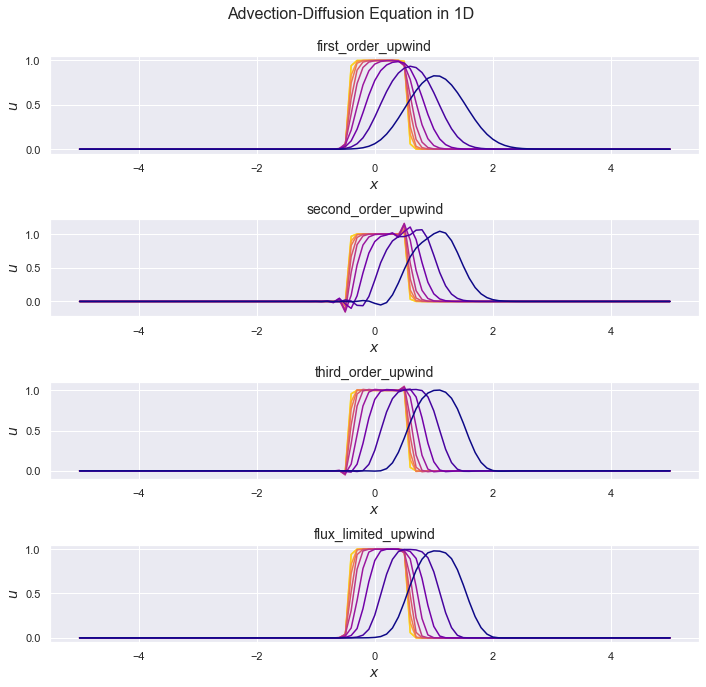

In [66]:
colormap = plt.get_cmap('plasma')
adv_solvers = [first_order_upwind, second_order_upwind, third_order_upwind, flux_limited_upwind]
fig, ax = plt.subplots(len(adv_solvers), 1, figsize=(10,10))
fig.suptitle('Advection-Diffusion Equation in 1D', fontsize=16)

def block(x): return np.array([int(i>=-0.5 and i<=0.5) for i in x])
for idx, solver in enumerate(adv_solvers):
    adv_x, adv_sol = solve_adv_eqn(solver=solver, a=0.5, D=0.01, T_end=2, dx=0.1, dt=0.01, initial_dist=block)
    ax[idx].set_title(solver.__name__, fontsize=14)
    ax[idx].set_xlabel(r'$x$', fontsize=14)
    ax[idx].set_ylabel(r'$u$', fontsize=14)
    ax[idx].set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
    for i in np.logspace(0, np.log10(np.size(adv_sol, axis=0)-1), num=10):
        ax[idx].plot(adv_x, adv_sol[int(i),])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
savepath = './'
plt.savefig(savepath+'{}.jpg'.format('upwind'), format='jpg', dpi=1000)
plt.show()